Fit simple models predicting female behavior from surrogate neural activity.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_lin, torch_fit_lin

cc = np.concatenate

NTR = 276
NTRAIN = int(round(.8*NTR))
NSPLIT = 30

FIT_LIN = skl_fit_lin
FIT_KWARGS = {}

# FIT_LIN = torch_fit_lin
# FIT_KWARGS = {nepoch=500, print_every=10}

In [2]:
# NRL_MDL = 'lin'  # linear neural model
NRL_MDL = 'dyn'  # dynamical neural model

DF_BAKER_FIT_PARAM = pd.read_csv(f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv') 

# ROI_SET, R_COLS_USE = 'all', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID]
# ROI_SET, R_COLS_USE = 'nonsoma', np.array([f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID])[DF_BAKER_FIT_PARAM.ROI != 'somas']
# ROI_SET, R_COLS_USE = 'soma', np.array([f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID])[DF_BAKER_FIT_PARAM.ROI == 'somas']
# ROI_SET, R_COLS_USE = 'dep', np.array([f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID])[(DF_BAKER_FIT_PARAM.X_S > 0)&(DF_BAKER_FIT_PARAM.X_P > 0)]
# ROI_SET, R_COLS_USE = 'hyp', np.array([f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID])[(DF_BAKER_FIT_PARAM.X_S < 0)&(DF_BAKER_FIT_PARAM.X_P < 0)]

TARG = 'FFV'
# TARG = 'FLS'
# TARG = 'FRS'


PFX_BEHAV = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}/mlv_c_baker_{NRL_MDL}'
SAVE_FILE = f'data/simple/mlv_c/neur_basic/c_baker_{NRL_MDL}_{ROI_SET}_{TARG.lower()}_{NTR}_tr.npy'

In [3]:
DF_BAKER_FIT_PARAM

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [4]:
# fit regression models
rgrs = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    rnd_tr_idxs = np.random.permutation(NTR)
    idxs_train = rnd_tr_idxs[:NTRAIN]
    idxs_test = rnd_tr_idxs[NTRAIN:]
    rgr = FIT_LIN(PFX_BEHAV, R_COLS_USE, TARG, idxs_train, idxs_test, **FIT_KWARGS)
    rgrs.append(rgr)

Split 0
Split 1


In [5]:
# save r2, weights, and example predictions
save_data = {
    'r2_train': np.array([rgr.r2_train for rgr in rgrs]),
    'r2_test': np.array([rgr.r2_test for rgr in rgrs]),
    'w': np.array([rgr.w for rgr in rgrs]),
    'ys_train': [rgr.ys_train for rgr in rgrs[:2]],
    'y_hats_train': [rgr.y_hats_train for rgr in rgrs[:2]],
    'ys_test': [rgr.ys_test for rgr in rgrs[:2]],
    'y_hats_test': [rgr.y_hats_test for rgr in rgrs[:2]],
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(R_COLS_USE)
}

np.save(SAVE_FILE, np.array([save_data]))

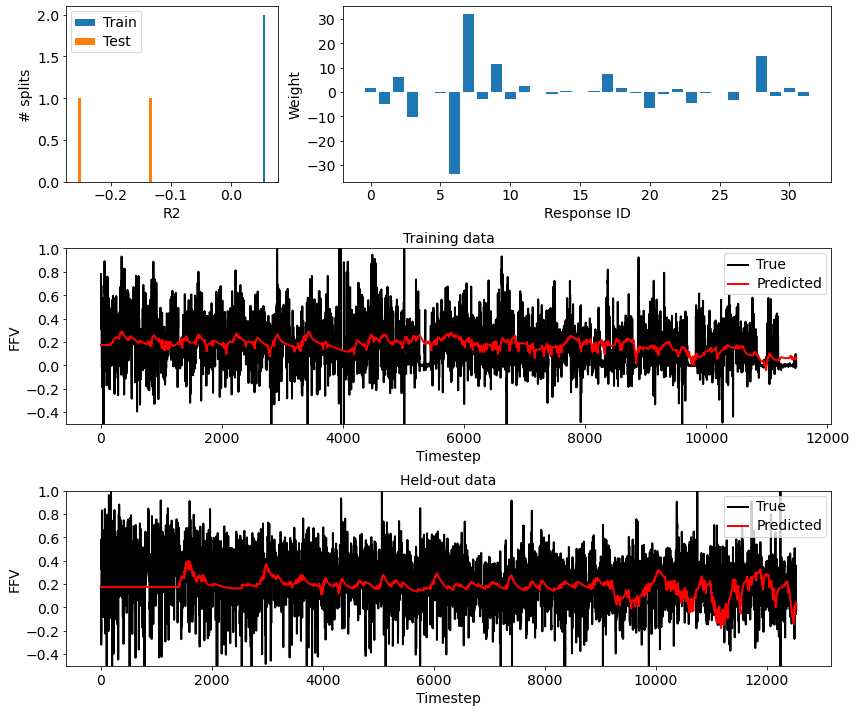

In [6]:
TRAIN_IDX_PLOT = 0
TEST_IDX_PLOT = 0

data = np.load(SAVE_FILE, allow_pickle=True)[0]
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10), tight_layout=True)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

axs[0].hist(np.transpose([data['r2_train'], data['r2_test']]), bins=30)
axs[0].legend(['Train', 'Test'])
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

axs[1].bar(np.arange(data['w'].shape[1]), np.mean(data['w'], axis=0))
set_plot(axs[1], x_label='Response ID', y_label='Weight', font_size=14)

axs[2].plot(np.arange(len(data['ys_train'][0][TRAIN_IDX_PLOT])), data['ys_train'][0][TRAIN_IDX_PLOT], c='k', lw=2)
axs[2].plot(np.arange(len(data['y_hats_train'][0][TRAIN_IDX_PLOT])), data['y_hats_train'][0][TRAIN_IDX_PLOT], c='r', lw=2)
axs[2].legend(['True', 'Predicted'])
set_plot(axs[2], y_lim=(-.5, 1), x_label='Timestep', y_label='FFV', title='Training data', font_size=14)

axs[3].plot(np.arange(len(data['ys_test'][0][TEST_IDX_PLOT])), data['ys_test'][0][TEST_IDX_PLOT], c='k', lw=2)
axs[3].plot(np.arange(len(data['y_hats_test'][0][TEST_IDX_PLOT])), data['y_hats_test'][0][TEST_IDX_PLOT], c='r', lw=2)
axs[3].legend(['True', 'Predicted'])
set_plot(axs[3], y_lim=(-.5, 1), x_label='Timestep', y_label='FFV', title='Held-out data', font_size=14)